In [1]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as  sns
import xarray as xr
import random 
import geopandas as gpd
from shapely.geometry import Point
import rioxarray as rxr

from keras import layers, models, metrics
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

import fiona
fiona.supported_drivers
fiona.drvsupport.supported_drivers['kml'] = 'rw' # enable KML support which is disabled by default
fiona.drvsupport.supported_drivers['KML'] = 'rw' # enable KML support which is disabled by default

import warnings
warnings.filterwarnings("ignore")
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
plt.rcParams['font.family'] = 'DejaVu Sans' 

2024-10-03 14:02:51.975897: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 14:02:51.989467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 14:02:51.993793: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 14:02:52.004594: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 14:02:52.860633: W tensorflow/compiler/tf2

## Feature Selection

In [83]:
training_nc = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/training_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp.nc",mask_and_scale=True).fillna(np.nan)
training_df = pd.DataFrame(training_nc.to_numpy().reshape(training_nc.shape[0]*training_nc.shape[1],training_nc.shape[2]),columns=training_nc.bands.to_numpy())
training_df

,Elev_mean,Elev_stdDev,LC_ratio,ACond_tavg_min,AvgSurfT_tavg_min,CanopInt_tavg_min,ECanop_tavg_min,ESoil_tavg_min,EvapSnow_tavg_min,Evap_tavg_min,...,LST_Day_1km_mean,LST_Night_1km_mean,ET_min,PET_min,ET_max,PET_max,ET_mean,PET_mean,precipitation_mean,lwe_thickness_csr_mean
0,0.446489,0.808189,-0.906000,0.535249,0.833277,-0.216801,0.043136,0.781951,0.025601,0.691280,...,0.387674,0.631920,0.315610,0.240282,0.250840,0.234291,0.248582,0.221636,-0.100501,0.008712
1,0.446489,0.808189,-0.906000,-0.289476,0.224357,-0.225367,0.038439,0.392084,0.025601,0.296165,...,0.099130,0.401450,-0.142493,-0.112684,-0.176261,-0.168451,-0.155920,-0.155440,-0.545467,-0.004829
2,0.446489,0.808189,-0.906000,-0.763756,-0.434289,-0.576540,-0.007888,-0.219030,-0.621581,-0.165534,...,-0.748889,-0.594719,-0.386389,-0.330641,-0.545644,-0.587895,-0.463238,-0.445340,1.251355,0.007151
3,0.446489,0.808189,-0.906000,-0.999943,-0.808279,1.355929,-0.832169,-0.432852,-2.062386,-0.587234,...,-0.729561,-0.391162,-0.483624,-0.412346,-0.596020,-0.657371,-0.514804,-0.511605,2.641252,0.034558
4,0.446489,0.808189,-0.906000,-0.822393,-0.640068,0.746327,-0.589380,-0.376370,-3.503191,-0.444473,...,-0.740476,-0.488450,-0.486601,-0.381726,-0.707297,-0.797730,-0.626054,-0.604300,1.526765,0.044761
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3733,-0.633506,-1.600404,-0.508102,-0.552667,-0.074962,8.166479,-0.107171,0.024744,-1.325432,-0.072191,...,-0.429567,-0.128909,-0.038707,-0.130636,-0.349361,-0.430681,-0.293403,-0.322535,-0.034919,-0.014395
3734,-0.633506,-1.600404,-0.508102,-0.612084,-0.233862,0.280526,0.050000,0.187100,-2.721499,0.156228,...,-0.289412,-0.243705,-0.025521,-0.049299,-0.097689,-0.161621,-0.172179,-0.174522,-0.012920,-0.016738
3735,-0.633506,-1.600404,-0.508102,-0.220809,-0.220194,-0.477303,0.041187,0.570257,-0.522038,0.233783,...,-0.000363,-0.034882,0.216488,0.225772,0.129900,0.092692,0.176033,0.169163,0.340018,-0.007636
3736,-0.633506,-1.600404,-0.508102,0.363013,0.188625,-0.495949,0.040673,0.344933,0.000000,0.622051,...,0.204982,0.244803,0.672054,0.583857,0.464179,0.419177,0.646605,0.594158,-0.957715,-0.032367


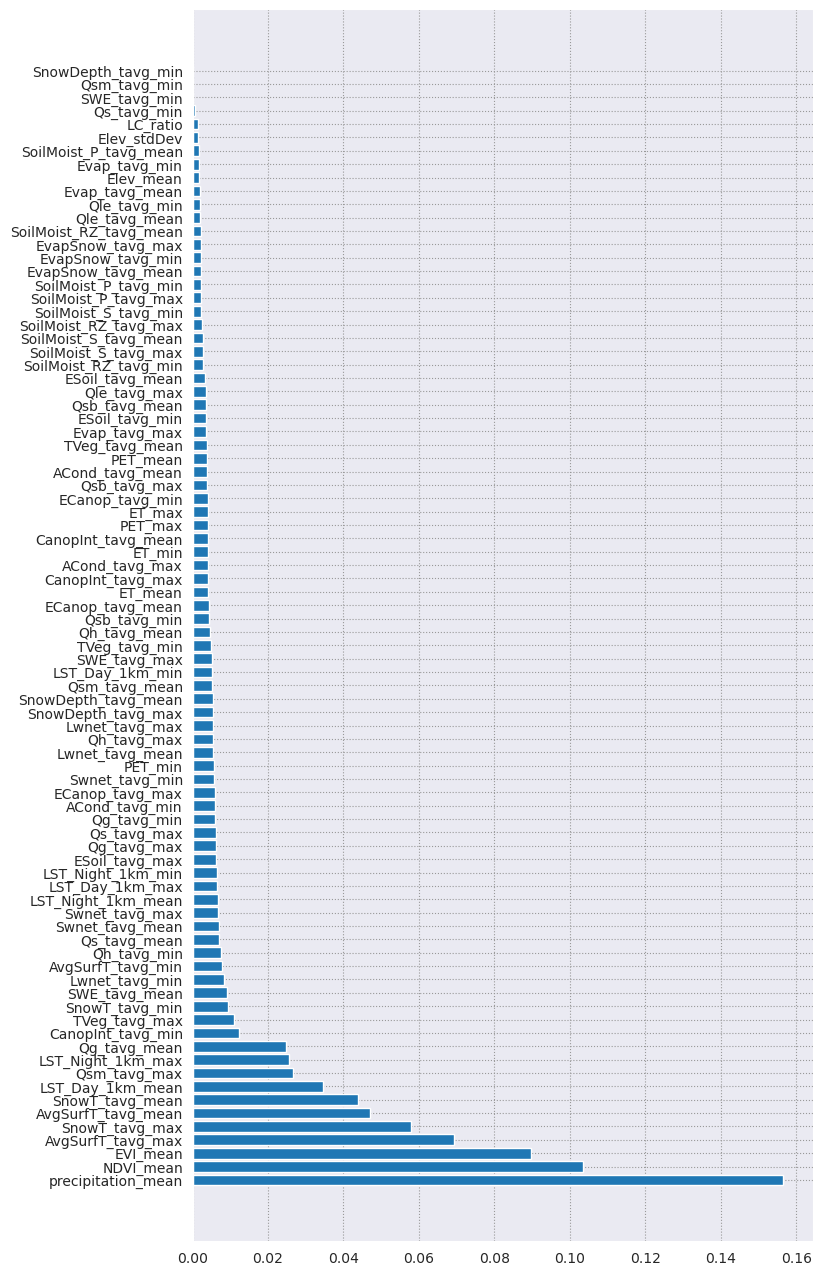

In [84]:
from sklearn.ensemble import RandomForestRegressor

X = training_df.iloc[:,:-1]
y = training_df.iloc[:,-1]

rf = RandomForestRegressor(n_estimators=200, random_state=42)
rf.fit(X, y)

# Get feature importances
importances = rf.feature_importances_

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
feature_importance_df

# plot the scores
plt.figure(figsize=(8,16))
plt.barh(feature_importance_df['feature'], feature_importance_df['importance'])
plt.show()

In [85]:
# Calculate cumulative importance
feature_importance_df['Cumulative Importance'] = feature_importance_df['importance'].cumsum()

# Set a cutoff threshold (e.g., 95% cumulative importance)
cutoff = 0.95

# Select features where cumulative importance is below the cutoff
selected_features = feature_importance_df[feature_importance_df['Cumulative Importance'] <= cutoff]['feature'].values

print("Selected features based on cumulative importance cutoff:")
print((selected_features))

Selected features based on cumulative importance cutoff:
['precipitation_mean' 'NDVI_mean' 'EVI_mean' 'AvgSurfT_tavg_max'
 'SnowT_tavg_max' 'AvgSurfT_tavg_mean' 'SnowT_tavg_mean'
 'LST_Day_1km_mean' 'Qsm_tavg_max' 'LST_Night_1km_max' 'Qg_tavg_mean'
 'CanopInt_tavg_min' 'TVeg_tavg_max' 'SnowT_tavg_min' 'SWE_tavg_mean'
 'Lwnet_tavg_min' 'AvgSurfT_tavg_min' 'Qh_tavg_min' 'Qs_tavg_mean'
 'Swnet_tavg_mean' 'Swnet_tavg_max' 'LST_Night_1km_mean' 'LST_Day_1km_max'
 'LST_Night_1km_min' 'ESoil_tavg_max' 'Qg_tavg_max' 'Qs_tavg_max'
 'Qg_tavg_min' 'ACond_tavg_min' 'ECanop_tavg_max' 'Swnet_tavg_min'
 'PET_min' 'Lwnet_tavg_mean' 'Qh_tavg_max' 'Lwnet_tavg_max'
 'SnowDepth_tavg_max' 'SnowDepth_tavg_mean' 'Qsm_tavg_mean'
 'LST_Day_1km_min' 'SWE_tavg_max' 'TVeg_tavg_min' 'Qh_tavg_mean'
 'Qsb_tavg_min' 'ECanop_tavg_mean' 'ET_mean' 'CanopInt_tavg_max'
 'ACond_tavg_max' 'ET_min' 'CanopInt_tavg_mean' 'PET_max' 'ET_max'
 'ECanop_tavg_min' 'Qsb_tavg_max' 'ACond_tavg_mean' 'PET_mean'
 'TVeg_tavg_mean' 'Evap_ta

In [ ]:
training_nc = training_nc.sel(bands=['Elev_mean', 'Elev_stdDev', 'LC_ratio']+list(selected_features)+['lwe_thickness_csr_mean'])
training_nc.to_netcdf("/home/jemima/Data/GRACE_ConvLSTM/training_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp_featuresel.nc")
training_nc

## Calculating Pixel Level Varience to Pixels for Splitting

In [66]:
import numpy as np

def calculate_variance_per_pixel(data):
    """
    Calculate the variance per pixel over time across all bands.
    
    Parameters:
    - data: 3D numpy array with shape (pixels, time, bands)
    
    Returns:
    - variance_per_pixel: 2D numpy array with shape (pixels, bands)
      containing the variance for each pixel across time for each band.
    - total_variance_per_pixel: 1D numpy array with shape (pixels,)
      containing the total variance (summed across all bands) for each pixel.
    """
    
    # Compute variance along the time axis (axis=1)
    variance_per_pixel = np.var(data, axis=1)
    
    # Sum variance across all bands to get total variance per pixel
    total_variance_per_pixel = np.sum(variance_per_pixel, axis=1)
    
    return variance_per_pixel, total_variance_per_pixel

In [67]:
import numpy as np

def split_by_variance(data, variance, split_idx=0.9):

    # Sort pixels by variance in descending order
    sorted_indices = np.argsort(variance)[::-1]

    # Split the data and labels based on the sorted indices
    split_index = int(sorted_indices.shape[0] * split_idx)

    train_indices = xr.concat([sorted_indices[:split_index-5], sorted_indices[-5:]], dim='locs')
    test_indices = sorted_indices[split_index-5:-5] 
    
    train_X = data.sel(locs=data.locs.to_numpy()[train_indices])
    test_X = data.sel(locs=data.locs.to_numpy()[test_indices])

    return train_X, test_X


training_da = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/training_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp_featuresel.nc", engine='netcdf4')

# Assuming `train_data` is your 3D numpy array with shape (pixels, time, bands)
variance_per_pixel, total_variance_per_pixel = calculate_variance_per_pixel(training_da)

train_arr, test_arr = split_by_variance(training_da, total_variance_per_pixel)
print(train_arr.shape, test_arr.shape)

(18, 178, 62) (3, 178, 62)


In [68]:
variance_per_pixel, total_variance_per_pixel = calculate_variance_per_pixel(train_arr)
print('Varience for Training Pixels - ',total_variance_per_pixel.to_numpy())

variance_per_pixel, total_variance_per_pixel = calculate_variance_per_pixel(test_arr)
print('Varience for Test Pixels - ',total_variance_per_pixel.to_numpy())

Varience for Training Pixels -  [19722.04784113  1048.16563655   603.59684261   573.06127424
   504.71723618   427.65128137   338.11188343   310.5972964
   265.14125344   259.3033107    249.89808539   232.85122657
   190.58046615    90.03916831    73.25610003    48.13949411
    47.67847149    43.4486676 ]
Varience for Test Pixels -  [186.9753018  164.20300971 102.16516562]


## Train Test Split

In [25]:
# Window length (time steps per sample)
def windowarr(arr , window_length = 48):

    # Initialize lists to store windowed data
    X = []
    # Loop through each pixel
    for pixel_idx in range(arr.shape[0]):
        # For each pixel, slide over the time series in windows of size `window_length`
        for i in range(arr.shape[1] - window_length + 1):
            window = arr[pixel_idx, i:i + window_length, :]
            X.append(window)

    # Convert the list to a numpy array
    X_arr = np.array(X)[:,:,:-1]
    y_arr = np.array(X)[:,:,-1]

    return X_arr  , y_arr

### Varience Based Split

In [69]:
train_X, train_y = windowarr(train_arr , window_length = 48)
test_X, test_y = windowarr(test_arr , window_length = 48)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2358, 48, 61) (2358, 48) (393, 48, 61) (393, 48)


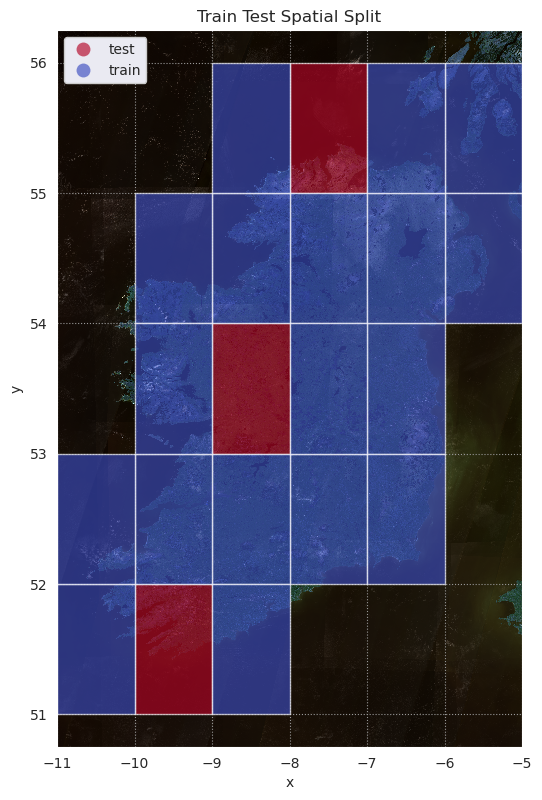

In [72]:
tif = rxr.open_rasterio("/home/jemima/Data/GRACE_ConvLSTM/Ireland_BKG_2.tif", masked=True)

x = [float(str(coord).split(',')[0]) for coord in test_arr[:,0,0].locs.to_numpy()]
y = [float(str(coord).split(',')[1]) for coord in test_arr[:,0,0].locs.to_numpy()]
df_test = pd.DataFrame(x,columns=['x'])
df_test['y'] = y
df_test['split'] = np.repeat('test',test_arr.shape[0])

x = [float(str(coord).split(',')[0]) for coord in train_arr[:,0,0].locs.to_numpy()]
y = [float(str(coord).split(',')[1]) for coord in train_arr[:,0,0].locs.to_numpy()]

df_train = pd.DataFrame(x,columns=['x'])
df_train['y'] = y
df_train['split'] = np.repeat('train',train_arr.shape[0])

df_train_test = pd.concat([df_test,df_train])
gdf_train_test = gpd.GeoDataFrame(df_train_test, crs="EPSG:4326", geometry=gpd.points_from_xy(df_train_test.x, df_train_test.y))

def buffer_with_square_cap(gdf, distance):
    gdf['geometry'] = gdf.geometry.buffer(distance, cap_style='square')
    return gdf

buffered_gdf = buffer_with_square_cap(gdf_train_test, 0.5)

fig,ax = plt.subplots(1,1,figsize=(6,10))
tif[1:4,:,:].plot.imshow(add_colorbar=False,ax=ax,vmin=0.005,vmax=0.25)
buffered_gdf.plot('split',cmap='coolwarm_r',legend=True,ax=ax,alpha=0.65,legend_kwds={'loc':'upper left','framealpha':1})
ax.set_title('Train Test Spatial Split')
ax.set_ylim(50.75,56.25)
ax.set_xlim(-11,-5)
plt.show()

### Random Spatial Split

In [72]:
training_da = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/training_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp_featuresel.nc", engine='netcdf4')

train_arr , test_arr = train_test_split(training_da, test_size=0.1, random_state=12)
print(train_arr.shape, test_arr.shape)

train_X, train_y = windowarr(train_arr , window_length = 48)
test_X, test_y = windowarr(test_arr , window_length = 48)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(18, 178, 62) (3, 178, 62)
(2358, 48, 61) (2358, 48) (393, 48, 61) (393, 48)


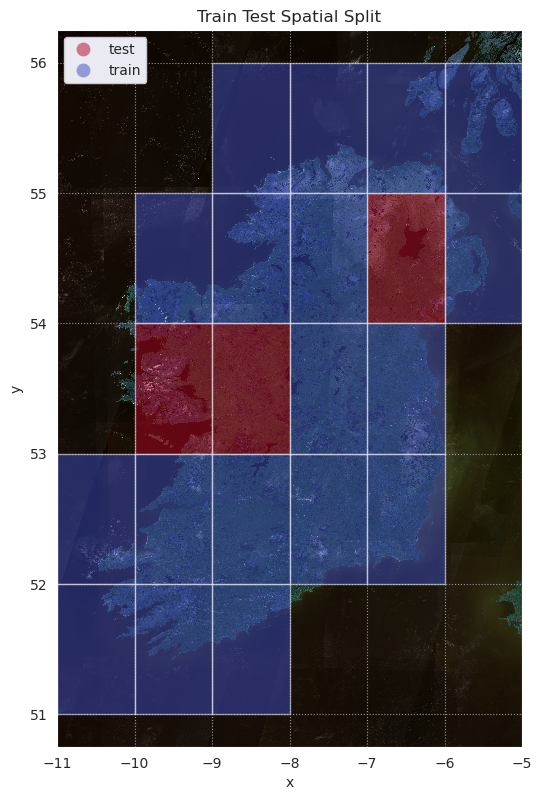

In [73]:
tif = rxr.open_rasterio("/home/jemima/Data/GRACE_ConvLSTM/Ireland_BKG_2.tif", masked=True)

x = [float(str(coord).split(',')[0]) for coord in test_arr[:,0,0].locs.to_numpy()]
y = [float(str(coord).split(',')[1]) for coord in test_arr[:,0,0].locs.to_numpy()]
df_test = pd.DataFrame(x,columns=['x'])
df_test['y'] = y
df_test['split'] = np.repeat('test',test_arr.shape[0])

x = [float(str(coord).split(',')[0]) for coord in train_arr[:,0,0].locs.to_numpy()]
y = [float(str(coord).split(',')[1]) for coord in train_arr[:,0,0].locs.to_numpy()]

df_train = pd.DataFrame(x,columns=['x'])
df_train['y'] = y
df_train['split'] = np.repeat('train',train_arr.shape[0])

df_train_test = pd.concat([df_test,df_train])
gdf_train_test = gpd.GeoDataFrame(df_train_test, crs="EPSG:4326", geometry=gpd.points_from_xy(df_train_test.x, df_train_test.y))

def buffer_with_square_cap(gdf, distance):
    gdf['geometry'] = gdf.geometry.buffer(distance, cap_style='square')
    return gdf

buffered_gdf = buffer_with_square_cap(gdf_train_test, 0.5)

fig,ax = plt.subplots(1,1,figsize=(6,10))
tif[1:4,:,:].plot.imshow(add_colorbar=False,ax=ax,vmin=0.005,vmax=0.25)
buffered_gdf.plot('split',cmap='coolwarm_r',legend=True,ax=ax,alpha=0.5,legend_kwds={'loc':'upper left','framealpha':1})
ax.set_title('Train Test Spatial Split')
ax.set_ylim(50.75,56.25)
ax.set_xlim(-11,-5)
plt.show()

### Temporal Split

In [25]:
training_da = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/training_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp_featuresel.nc")

arr_X = windowarr(training_da)
train_arr , test_arr = train_test_split(arr_X, test_size=0.1, random_state=21)

print(train_arr.shape, test_arr.shape)

train_X, train_y = train_arr[:,:,:-1] , train_arr[:,:,-1]
test_X, test_y = test_arr[:,:,:-1] , test_arr[:,:,-1]

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2475, 48, 62) (276, 48, 62)
(2475, 48, 61) (2475, 48) (276, 48, 61) (276, 48)


In [37]:
training_da = xr.open_dataarray("/home/jemima/Data/GRACE_ConvLSTM/training_stacks/processed_stacks/LSTM_training_clean_robustnorm_naninterp_featuresel.nc")

train_X, train_y = windowarr(training_da[:,:140,:] , window_length = 24)
test_X, test_y = windowarr(training_da[:,140:,:] , window_length = 24)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2457, 24, 61) (2457, 24) (315, 24, 61) (315, 24)


# LSTM Model Build

Epoch 1/500


295/295 - 6s - 20ms/step - loss: 0.0011 - mae: 0.0202 - r2_score: -2.0531e+00 - root_mean_squared_error: 0.0301 - val_loss: 5.5990e-04 - val_mae: 0.0116 - val_r2_score: 0.2399 - val_root_mean_squared_error: 0.0147
Epoch 2/500
295/295 - 4s - 14ms/step - loss: 4.0469e-04 - mae: 0.0120 - r2_score: 0.2167 - root_mean_squared_error: 0.0153 - val_loss: 2.5336e-04 - val_mae: 0.0108 - val_r2_score: 0.3417 - val_root_mean_squared_error: 0.0137
Epoch 3/500
295/295 - 4s - 14ms/step - loss: 1.9297e-04 - mae: 0.0111 - r2_score: 0.3265 - root_mean_squared_error: 0.0141 - val_loss: 1.3576e-04 - val_mae: 0.0105 - val_r2_score: 0.3656 - val_root_mean_squared_error: 0.0134
Epoch 4/500
295/295 - 4s - 14ms/step - loss: 1.1998e-04 - mae: 0.0108 - r2_score: 0.3662 - root_mean_squared_error: 0.0137 - val_loss: 1.0180e-04 - val_mae: 0.0104 - val_r2_score: 0.3711 - val_root_mean_squared_error: 0.0133
Epoch 5/500
295/295 - 4s - 14ms/step - loss: 9.7954e-05 - mae: 0.0105 - r2_score: 0.3931 - root_mean_squared_er

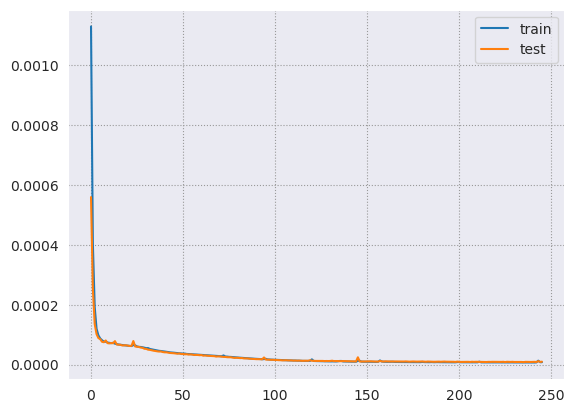

In [84]:
nodes_l1 = 320
nodes_l2 = 128
nodes_l3 = 96
activation = 'linear'
reg = l2(1.439279420422431e-05)
lr = 0.0009133436118407579
loss_func = Huber(delta=0.5)
batch_size = 8

model = models.Sequential()
model.add(layers.LSTM(nodes_l1, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(layers.Dropout(0.5))

model.add(layers.LSTM(nodes_l2, return_sequences=True))
model.add(layers.Dropout(0.4))

model.add(layers.LSTM(nodes_l3, return_sequences=False))
#model.add(layers.Dropout(0.1))

model.add(layers.Dense(train_X.shape[1], activation=activation, kernel_regularizer=reg))

model.compile(optimizer=Adam(learning_rate=lr), loss=loss_func, 
              metrics=['mae',metrics.RootMeanSquaredError(),metrics.R2Score()])


# Reduce learning rate when a metric has stopped improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# fit network
history = model.fit(train_X, train_y, 
                    epochs=500, batch_size=batch_size, 
                    validation_data=(test_X, test_y), 
                    verbose=2, shuffle=True,
                    callbacks=[early_stopping]) 

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [85]:
model_v = 'v7'
model.save("/home/jemima/Data/GRACE_ConvLSTM/models_lstm/lstm_model_"+str(model_v)+".keras")

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R squared (train):  0.9800522695255709
R squared (test):  0.9640003470418151


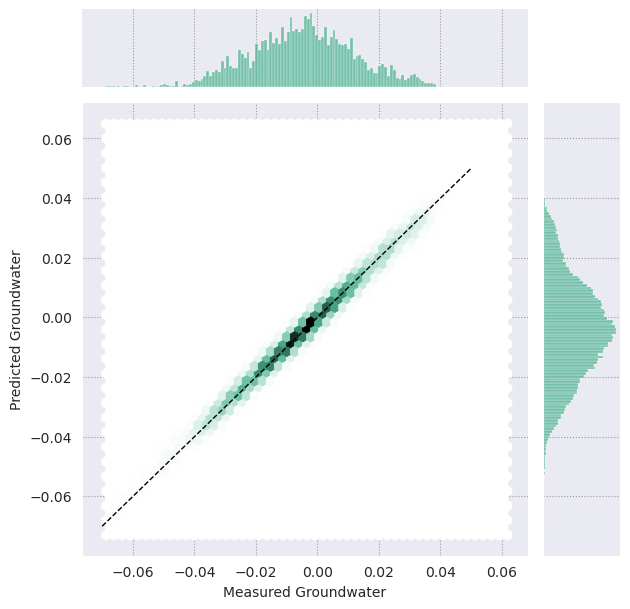

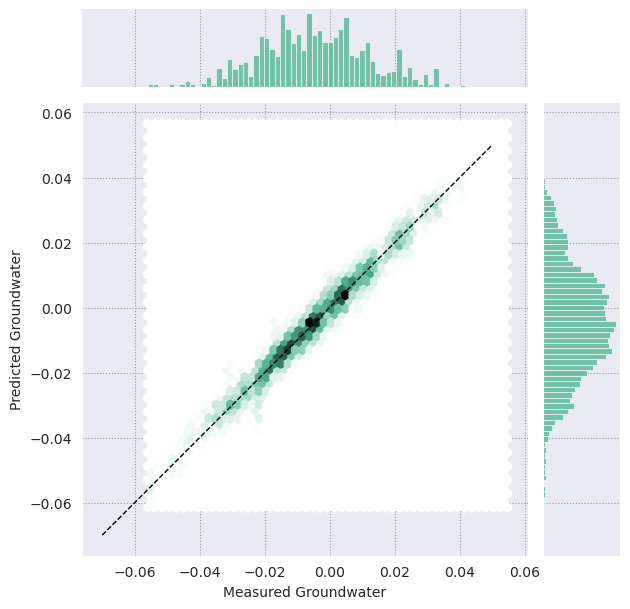

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


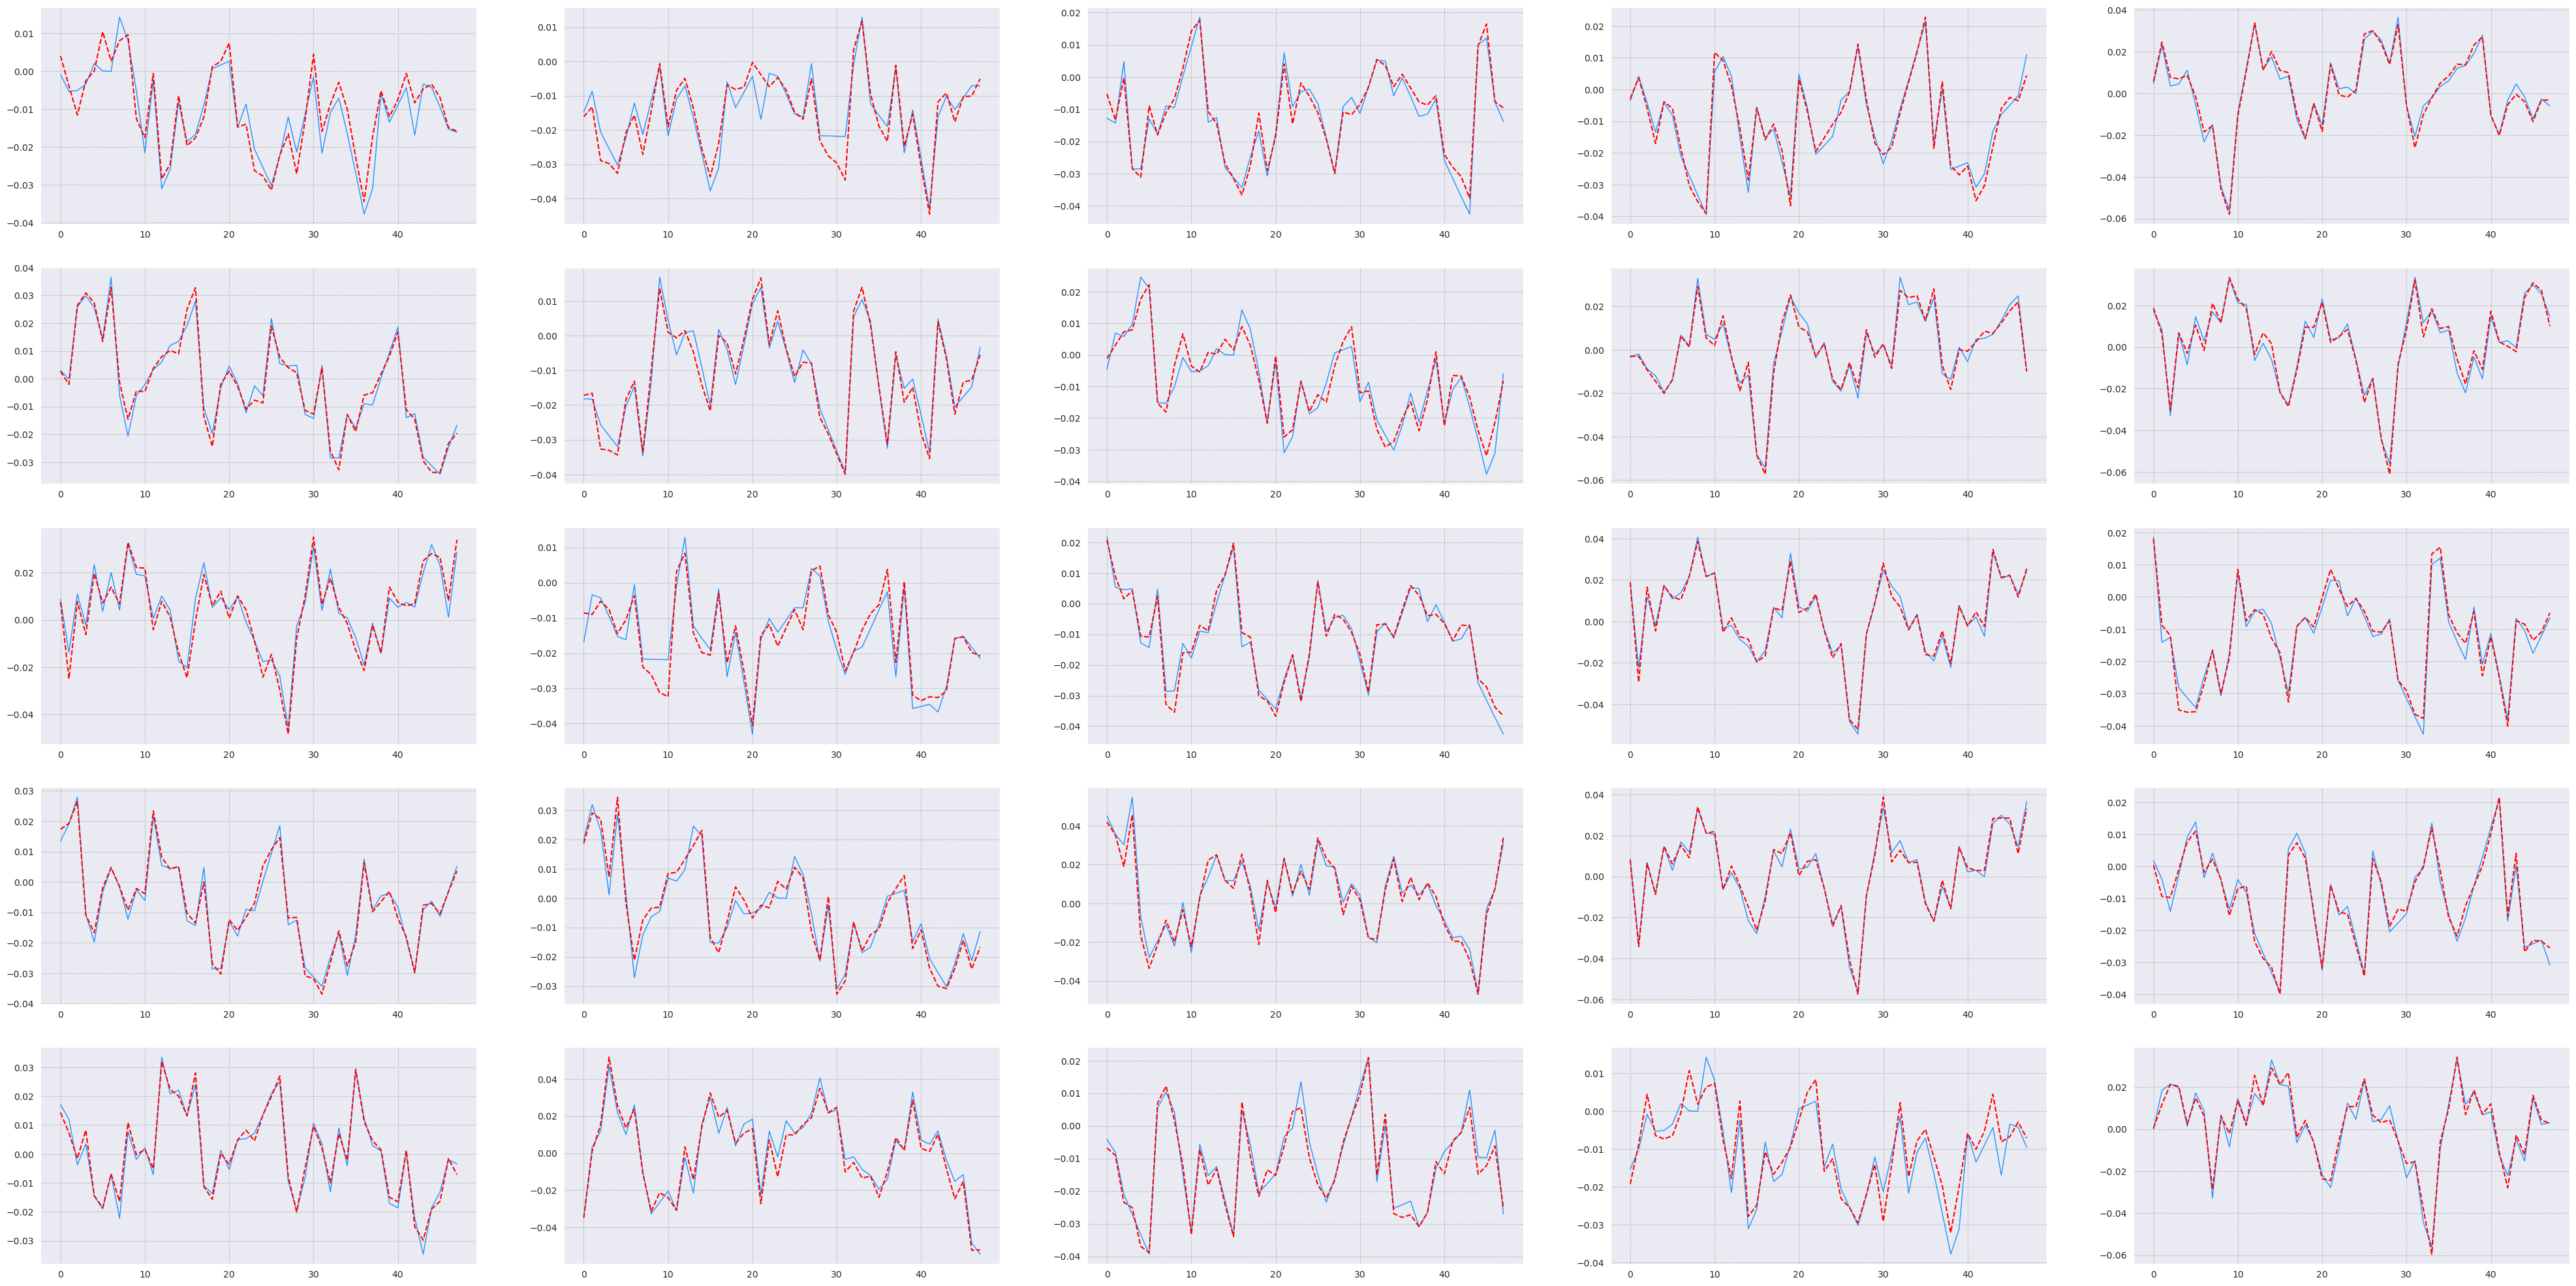

In [87]:
#model = tf.keras.models.load_model("/home/jemima/Data/GRACE_ConvLSTM/models_lstm/lstm_model_"+str(model_v)+".keras")

train_actual = train_y.flatten()
train_predicted = model.predict(train_X[:,:,:]).flatten()
test_actual = test_y.flatten()
test_predicted = model.predict(test_X[:,:,:]).flatten()

R_squared_train = r2_score(train_actual, train_predicted)
R_squared_test = r2_score(test_actual, test_predicted)

print("R squared (train): ", R_squared_train)
print("R squared (test): ", R_squared_test)

sns.jointplot(x=train_actual, y=train_predicted, kind="hex", color="#4CB391")  
plt.plot([-0.07, 0.05], [-0.07, 0.05], 'k--', lw=1)
plt.xlabel('Measured Groundwater')
plt.ylabel('Predicted Groundwater')
plt.savefig('/home/jemima/Data/GRACE_ConvLSTM/models_lstm/plots/train_dist_'+str(model_v)+'.png')
plt.show()

sns.jointplot(x=test_actual, y=test_predicted, kind="hex", color="#4CB391")
plt.plot([-0.07, 0.05], [-0.07, 0.05], 'k--', lw=1)
plt.xlabel('Measured Groundwater')
plt.ylabel('Predicted Groundwater')
plt.savefig('/home/jemima/Data/GRACE_ConvLSTM/models_lstm/plots/test_dist_'+str(model_v)+'.png')
plt.show()

plt.figure(figsize=(50, 25))
for i, n in zip(range(25), random.sample(range(test_X.shape[0]), 25)):
    plt.subplot(5,5,i+1)
    pred = model.predict(np.expand_dims(test_X[n,:,:],axis=0))
    plt.plot(test_y[n,:].flatten(), linewidth=1, c='dodgerblue')
    plt.plot(pred.flatten(),'--', c='red')
plt.savefig('/home/jemima/Data/GRACE_ConvLSTM/models_lstm/plots/ts_samples_'+str(model_v)+'.png')
plt.show()


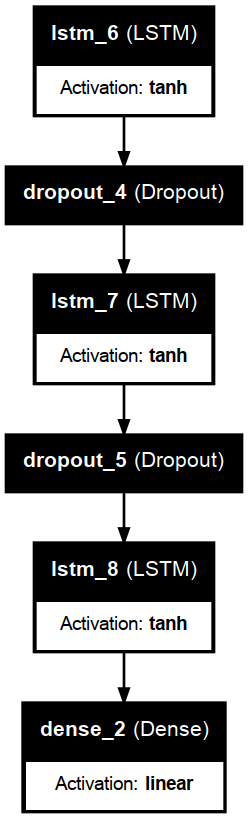

In [88]:
import keras
keras.utils.plot_model(
    model,
    to_file="/home/jemima/Data/GRACE_ConvLSTM/models_lstm/plots/modelplot_"+str(model_v)+".png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=False,
)

# Model Tuning

In [ ]:
def build_model(hp):
    model = models.Sequential()

    # Tuning number of LSTM nodes for each layer
    nodes_l1 = hp.Int('nodes_l1', min_value=128, max_value=512, step=64)
    nodes_l2 = hp.Int('nodes_l2', min_value=64, max_value=256, step=64)
    nodes_l3 = hp.Int('nodes_l3', min_value=32, max_value=128, step=32)

    # Tuning the number of LSTM layers
    num_layers = hp.Choice('num_lstm_layers', values=[1, 2, 3])
    
    # First LSTM layer
    model.add(layers.LSTM(nodes_l1, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=(num_layers > 1)))
    
    # Optional Dropout after first LSTM layer
    if hp.Boolean('dropout_1'):
        model.add(layers.Dropout(rate=hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)))


    # Add the second LSTM layer if number of layers is greater than 1
    if num_layers >= 2:
        model.add(layers.LSTM(nodes_l2, return_sequences=(num_layers > 2)))  # Only return sequences if a 3rd layer exists
        
        # Optional Dropout after second LSTM layer
        if hp.Boolean('dropout_2'):
            model.add(layers.Dropout(rate=hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Add the third LSTM layer if number of layers is 3
    if num_layers == 3:
        model.add(layers.LSTM(nodes_l3, return_sequences=False))
        
        # Optional Dropout after third LSTM layer
        if hp.Boolean('dropout_3'):
            model.add(layers.Dropout(rate=hp.Float('dropout_rate_3', min_value=0.1, max_value=0.5, step=0.1)))

    # Dense output layer
    model.add(layers.Dense(train_X.shape[1], 
                           activation=hp.Choice('activation', values=['linear']),
                           kernel_regularizer=l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='log'))))
    
    # Compile model with tunable learning rate and Huber loss delta
    lr = hp.Float('learning_rate', min_value=1e-5, max_value=1e-3, sampling='log')
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss=Huber(delta=hp.Float('delta', min_value=0.5, max_value=2.0, step=0.5)),
                  metrics=['mae', metrics.RootMeanSquaredError(), metrics.R2Score()])
    
    return model

# Set up tuner for hyperparameter search
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=100,
    factor=3,
    directory='/home/jemima/Data/GRACE_ConvLSTM/LSTM_tuning_spatialSplit_varsplit/',
    project_name='grace_tuning_lstm'
)

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


# Start tuning to find the best hyperparameters
tuner.search(train_X, train_y, 
             epochs=50,  # Train for fewer epochs during tuning
             validation_data=(test_X, test_y),
             callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the best model with the optimal hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model on the full dataset
history = best_model.fit(train_X, train_y, 
                         epochs=500, 
                         validation_data=(test_X, test_y), 
                         callbacks=[early_stopping])

# Visualize the loss over time
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Display the best hyperparameters
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")